In [1]:
import numpy as np
import json, random
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

SEED = 42
random.seed(SEED); np.random.seed(SEED)

try:
    import torch
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
except Exception:
    torch = None

## Data Inspection

In [2]:
from pyspectral.dataset import SpectraPair
from pyspectral.config import DATA_DIR

DATA = DATA_DIR
ANN  = DATA / "annotations_S80.csv"

pairs, arts = SpectraPair.from_annotations(ANN, DATA)
X = pairs.X_raw.astype(np.float32)   # (N,C)
Y = pairs.Y_proc.astype(np.float32)  # (N,C)
N, C = X.shape

# for known grid, set it here for visuals later
H, W = 8, 8
assert N == H*W, f"Expected {H}x{W} grid -> N={H*W}, got N={N}"

plt.plot(X.mean(0), label="Raw mean"); plt.plot(Y.mean(0), label="LabSpec mean");
plt.legend(); plt.title("Mean spectra"); plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

### Blocked CV groups (2×2 tiles)

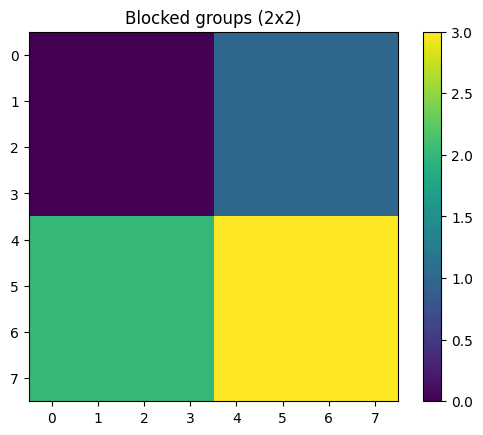

In [3]:
def tile_groups(H:int, W:int, tiles_h:int=2, tiles_w:int=2) -> np.ndarray:
    g = np.zeros((H, W), dtype=np.int32)
    for r in range(H):
        for c in range(W):
            g[r,c] = (r * tiles_h // H) * tiles_w + (c * tiles_w // W)
    return g.ravel()

groups = tile_groups(H, W, 2, 2)
plt.imshow(groups.reshape(H,W)); plt.title("Blocked groups (2x2)"); plt.colorbar(); plt.show()

## Baselines

### Classical Baseline

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error as RMSE

cv = KFold(n_splits=4, shuffle=True, random_state=42)

# SpectraPair helpers
yhat_diag  = pairs.diagonal_affine_predict(cv)                   
yhat_pcr   = pairs.pcr_predict(cv)
yhat_enet  = pairs.multitask_elasticnet_predict(cv)

print(f"Diagonal affine (OOF) RMSE: {RMSE(Y, yhat_diag):.4f}")
print(f"PCR (OOF) RMSE:             {RMSE(Y, yhat_pcr):.4f}")
print(f"ElasticNet (OOF) RMSE:      {RMSE(Y, yhat_enet):.4f}")


100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:40<00:00, 10.19s/it]

Diagonal affine (OOF) RMSE: 0.7531
PCR (OOF) RMSE:             0.7745
ElasticNet (OOF) RMSE:      0.0072


### Train a low-rank linear neural network mapper & cache OOF preds

In [5]:
from pyspectral.modeling.train import cv_train_model
from pyspectral.config import ModelType
rank = 12

oof_stats = cv_train_model(
    spectral_pairs=pairs,
    arts=arts,
    n_splits=4,
    groups=groups,       
    epochs=10, # tested 10-20 is around where improvement stops
    lr=2e-4,
    # TODO: use lambda penalty class for penalty settings; new API
    #lam_id=1e-2,
    #lam_band=0.0,
    model_type=ModelType.LRSM,  # or ModelType.LRSM
    rank=rank,
    verbose=True,
)

print(oof_stats) 
LR_pred = oof_stats.pred_orig  # (N,C) in original units


 25%|██████████████████▌                                                       | 1/4 [03:33<10:39, 213.23s/it]

Fold 1/4 | train loss=0.284 | test MSE=0.251 | best test RMSE=0.456 | frac improved vs identity=0.875


 50%|█████████████████████████████████████                                     | 2/4 [06:19<06:11, 185.57s/it]

Fold 2/4 | train loss=0.284 | test MSE=0.342 | best test RMSE=0.535 | frac improved vs identity=0.812


 75%|███████████████████████████████████████████████████████▌                  | 3/4 [10:53<03:45, 225.77s/it]

Fold 3/4 | train loss=0.29 | test MSE=0.345 | best test RMSE=0.566 | frac improved vs identity=0.625


100%|██████████████████████████████████████████████████████████████████████████| 4/4 [15:34<00:00, 233.65s/it]

Fold 4/4 | train loss=0.287 | test MSE=0.347 | best test RMSE=0.524 | frac improved vs identity=0.812
OOF RMSE (standardized space): 0.563214
Diagonal affine OOF RMSE (std):  0.676263
Diagonal affine OOF RMSE (orig): 0.006807
OOF RMSE (original units):    0.005897


## Summarize models

In [6]:
import polars as pl
df = pl.DataFrame(
    {
        "model": ["diag_affine", "PCR", "ElasticNet", f"LowRank_r{rank}"],
        "oof_rmse": [RMSE(Y, yhat_diag), RMSE(Y, yhat_pcr), RMSE(Y, yhat_enet), RMSE(Y, LR_pred)]
    }
).sort("oof_rmse") # sort table in terms of rmse
df

model,oof_rmse
str,f64
"""LowRank_r12""",0.005527
"""ElasticNet""",0.007183
"""diag_affine""",0.753089
"""PCR""",0.774487


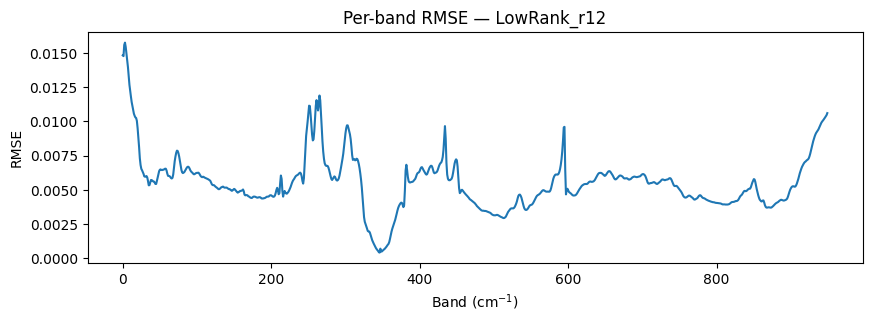

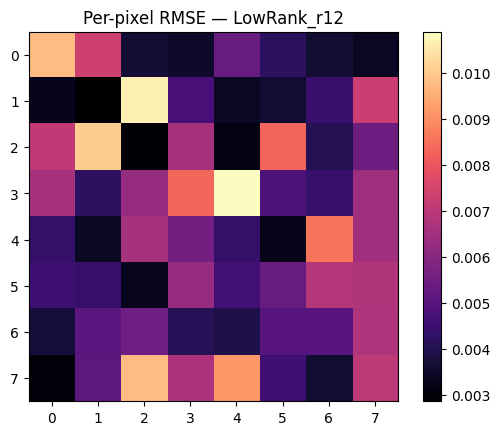

In [11]:
from pyspectral.plots import rmse_per_pixel
best_name, best_rmse = df["model"][0], df["oof_rmse"][0]
# .get acts as a default arg
best_pred = {"diag_affine": yhat_diag, "PCR": yhat_pcr, "ElasticNet": yhat_enet}.get(best_name, LR_pred)
x_label = r"Band ($\text{cm}^{-1}$)"
per_band_rmse_best = np.sqrt(((Y - best_pred)**2).mean(axis=0))
plt.figure(figsize=(10,3)); plt.plot(per_band_rmse_best); plt.title(f"Per-band RMSE — {best_name}"); plt.xlabel(x_label); plt.ylabel("RMSE"); plt.show()

if best_name != f"LowRank_r{rank}":
    # also show neural network output if not the best prediction
    per_band_rmse_lrsm = np.sqrt(((Y - LR_pred)**2).mean(axis=0))
    plt.figure(figsize=(10,3)); plt.plot(per_band_rmse_lrsm); plt.title(f"Per-band RMSE — {f"LowRank_r{rank}"}"); plt.xlabel(x_label); plt.ylabel("RMSE"); plt.show()

rmse_px = rmse_per_pixel(Y, best_pred).reshape(H,W)
plt.imshow(rmse_px, cmap="magma"); plt.colorbar(); plt.title(f"Per-pixel RMSE — {best_name}"); plt.show()

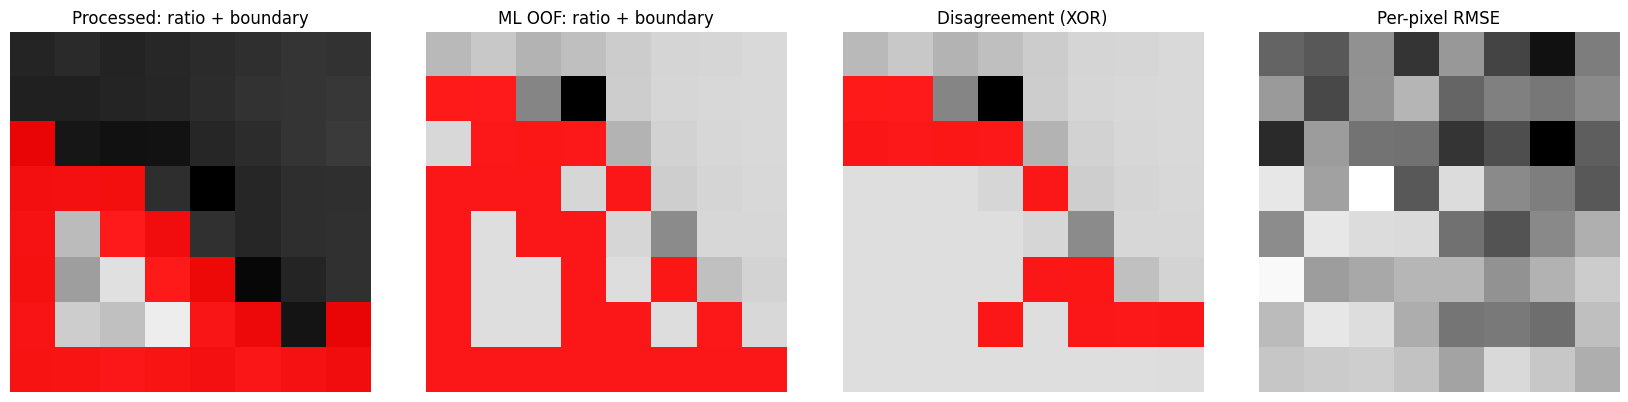

In [8]:
import pyspectral.modeling.predict as predict
import pyspectral.plots as plot
import importlib
importlib.reload(predict); importlib.reload(plot);
scene_idx = 0  # pick a scene 
pdata = predict.predict_cube(scene_idx, oof_stats, base_dir=DATA, csv_path=ANN)
metrics = plot.compare_boundaries(pdata, vid_labels=None)

